In [1]:
import os
import sys
from pathlib import Path
import numpy as np
from scipy.ndimage import zoom

repo_root = Path.cwd().parent
sys.path.append(str(repo_root))

folder_name = os.path.join(r'\\10.229.121.108','Workspace','PAT LINEAR','PATDOTUS','01')
from src.load_data_utils import list_subfolders, linear_pa_param
from src.pat_utils import pa_das_linear, generate_imaging_matrix, apply_tgc
import matplotlib.pyplot as plt

all_folders = list_subfolders(folder_name)
print(f"Found {len(all_folders)} image folders")
info = linear_pa_param()

Found 31 image folders


In [ ]:
input_dir = all_folders[24]
apod_method = 'kaiser'
coherence_method = 'cf'
Z_display = 4e-2
RF_Sum, RF_env_raw = pa_das_linear(input_dir, info, apod_method, coherence_method)

In [ ]:
# Dynamic Ranging
dB_PA = 25
min_dB = 10 ** (-dB_PA / 20.0)
RF_tgc = apply_tgc(RF_env_raw, info, alpha=20.0)
RF_env_norm = RF_tgc / np.max(RF_tgc) if np.max(RF_tgc) != 0 else RF_tgc
# RF_log = (20/dB_US)*log10(RF_env_norm)+1
with np.errstate(divide='ignore', invalid='ignore'):
    RF_log = (20.0 / dB_PA) * np.log10(np.maximum(RF_env_norm, 1e-20)) + 1.0
RF_log[RF_env_norm < min_dB] = 0.0
    
# Compute target image size
z_range = np.max(info.d_sample)
xz_ratio = info.FOV / z_range
Lx = int(4 * info.N_sc * 2.0/3.0)
Lz = int(round(4 * info.N_sc / xz_ratio)) if xz_ratio != 0 else RF_log.shape[0]
# Use scipy.ndimage.zoom to resize to (Lz, Lx)
zoom_z = Lz / RF_log.shape[0] if RF_log.shape[0] > 0 else 1.0
zoom_x = Lx / RF_log.shape[1] if RF_log.shape[1] > 0 else 1.0
RF_log_resized = zoom(RF_log, (zoom_z, zoom_x), order=1)
print(RF_log_resized.shape)
idx_z = int(Z_display / z_range * RF_log_resized.shape[0])
print(f"Display at z={Z_display*1e3:.1f} mm, index {idx_z} of {RF_log_resized.shape[0]}")
plt.imshow(RF_log_resized[0:idx_z,:], cmap='hot', vmin=0.0, vmax=1.0)
plt.show()

In [2]:
bbox_cm = (-1.0, 1.0, 0.0, 4.0)
scaling_factor = (20.0, 25.0)
G, meta = generate_imaging_matrix(bbox_cm , scaling_factor, info, verbose=True)

Imaging grid: x from -1.0 cm to 1.0 cm with dx=0.19 cm (12 points)
              z from 0.0 cm to 4.0 cm with dz=0.24 cm (18 points)
Time axis: 1398 points, from 0.00 us to 34.93 us
System matrix generated. G has shape (178944, 216) (dtype=float64)


In [3]:
Nt = meta['t'].size  # number of time samples per element
Nz, Nx = meta['Z'].shape
spatial_index = 100

iz = spatial_index // Nx
ix = spatial_index % Nx
x = meta['X'][iz, ix]
z = meta['Z'][iz, ix]
print(f"Voxel index {spatial_index} at (x,z)=({x*100:.1f} cm, {z*100:.1f} cm)")

t_tilde = np.sqrt(x ** 2 + z ** 2) / info.c
print(f"Theoretical arrival time {t_tilde*1e6:.2f} us")

Voxel index 100 at (x,z)=(-0.2 cm, 1.9 cm)
Theoretical arrival time 12.59 us


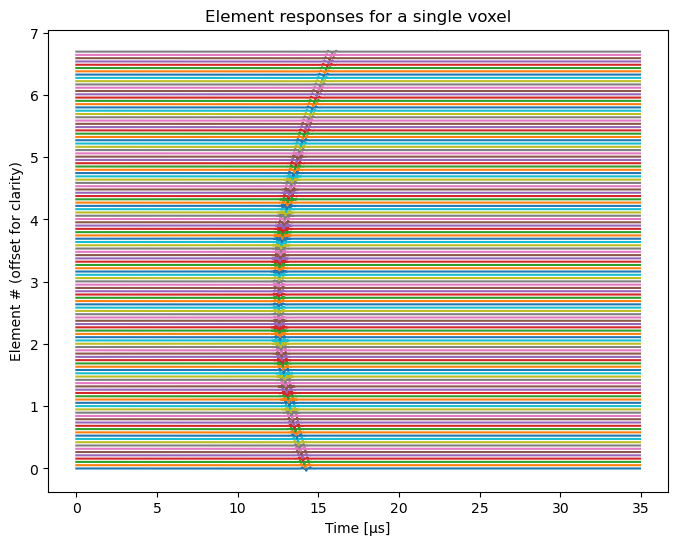

In [4]:
g_test = G[: , spatial_index].reshape(int(info.N_ele), -1).T
sir_max, sir_min = g_test.max(), g_test.min()
sir_max = np.max(np.abs([sir_max, sir_min]))
plt.figure(figsize=(8,6))
for ie in range(128):
    plt.plot(np.arange(Nt)/info.fs*1e6, g_test[:,ie] + ie*sir_max)  # offset for visualization
plt.xlabel('Time [µs]')
plt.ylabel('Element # (offset for clarity)')
plt.title('Element responses for a single voxel')
plt.show()

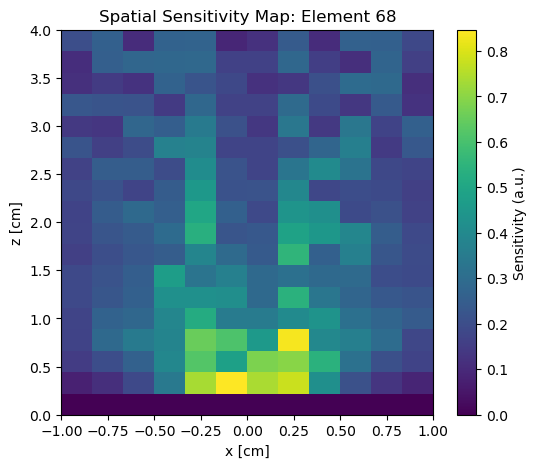

In [5]:
element_idx = 68  # for example
# Extract G rows corresponding to the element
rows = slice(element_idx*Nt, (element_idx+1)*Nt)  # time indices for this element
G_element = G[rows, :]  # shape (Nt, Nvox)
sensitivity_map = np.sum(np.abs(G_element), axis=0)  # shape (Nvox,)
sensitivity_map = sensitivity_map.reshape(Nz, Nx) 
x_min, x_max, z_min, z_max = bbox_cm
plt.figure(figsize=(6,5))
plt.imshow(sensitivity_map, origin='lower', extent=[x_min, x_max, z_min, z_max],
           aspect='auto', cmap='viridis')
plt.colorbar(label='Sensitivity (a.u.)')
plt.xlabel('x [cm]')
plt.ylabel('z [cm]')
plt.title(f'Spatial Sensitivity Map: Element {element_idx}')
plt.show()